# Дипломная работа по средней аналитике

## Постановка задачи
Как и любой бизнес, компания «Мегафон» хочет повысить удовлетворённость своих клиентов качеством услуг. Это важная задача для удержания пользователей — как давних, так и недавно привлечённых. Ведь затраты на маркетинг и продвижение не оправдаются, если клиент уйдёт из-за низкого качества связи. Однако в реальном мире ресурсы всегда ограничены, и в единицу времени технический отдел может решить конечное количество задач.
Чтобы делать это наиболее эффективно, важно определить, какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов, и в первую очередь направить ресурсы на работу с ними. Для этого «Мегафон» провёл опрос своих клиентов, предложив им оценить уровень удовлетворённости качеством связи. По каждому клиенту, прошедшему опрос, были собраны технические показатели.<br>

**Задача:** проанализировать, как зависит (и зависит ли) оценка, которую ставит клиент в опросе, от технических показателей, которые были собраны.



## Описание опроса

В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую. Ниже вы можете ознакомиться с инфографикой по структуре опроса.

# Блок-схема опроса
<img src="https://sun9-32.userapi.com/C6vN5pHQW7hlseIt0AtTN7qNDQbDnHXdt1P2NA/ILntXqa-RrA.jpg" title="Схема опроса пользователей компанией Мегафон">

## Загрузка и описание данных

In [1]:
# Импорт всех необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import numpy as np
from scipy.stats import ttest_ind
import os.path
import requests

In [2]:
df = pd.read_csv('megafon.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

In [3]:
df.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


### Описание данных
Описание колонок данных дано внизу. В частности, из общих соображений, для параметров сети сделано предположение, как данный параметр должен влиять на оценку респондента.
<table><tr><th>колонка в таблице данных</th><th>описание</th><th>доролнительное описание</th><th>как влияет</th></tr><tr><th>user_id</th><td>идентификатор абонента</td><td></td><td></td></tr><tr><th>Q1</th><td>ответ на первый вопрос</td><td></td><td></td></tr><tr><th>Q2</th><td>ответ на второй вопрос</td><td></td><td></td></tr><tr><th>Total Traffic(MB)</th><td>объем трафика передачи данных</td><td>Насколько активно абонент использует мобильный интернет</td><td></td></tr><tr><th>Downlink Throughput(Kbps)</th><td>средняя скорость «к абоненту»</td><td>Считается по всему трафику передачи данных.</td><td>больше-лучше</td><td></td></tr><tr><th>Uplink Throughput(Kbps)</th><td>средняя скорость «от абонента»</td><td>Считается по всему трафику передачи данных.</td><td>больше-лучше</td><td></td></tr><tr><th>Downlink TCP Retransmission Rate(%)</th><td>частота переотправок пакетов «к абоненту»</td><td>Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.</td><td>больше-хуже</td><td></td></tr><tr><th>Video Streaming Download Throughput(Kbps)</th><td>скорость загрузки потокового видео</td><td>меньше прерываний и лучше качество картинки</td><td>больше-лучше</td><td></td></tr><tr><th>Video Streaming xKB Start Delay(ms)</th><td>задержка старта воспроизведения видео</td><td>Сколько времени пройдёт между нажатием на кнопку Play<br> и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.</td><td>больше-хуже</td><td></td></tr><tr><th>Web Page Download Throughput(Kbps)</th><td>скорость загрузки web-страниц через браузер</td><td></td><td>больше-лучше</td><td></td></tr><tr><th>Web Average TCP RTT(ms)</th><td>пинг при просмотре web-страниц</td><td>Чем меньше, тем лучше — быстрее загружаются web-страницы</td><td>больше-хуже</td><td></td></tr></table>
<br>
Технический показатель `Total Traffic(MB)` представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

## Подготовка данных

### Интерпретация пропущенных значений

Данные состоят из 3112 строк. Таким образом, выборка очень маленькая, по-видимому, представлена лишь часть всех данных. В колонках `Q1` и `Q2` присутствуют пустые значения. В колонке `Q1` их всего два, они никак не влияют на общую статистику: их можно просто отбросить.
Первое предположение по поводу пустых значений в колонке `Q2`: они соответствуют той части пользователей, которая не добралась до ответа на второй вопрос в соответствии со схемой опроса.

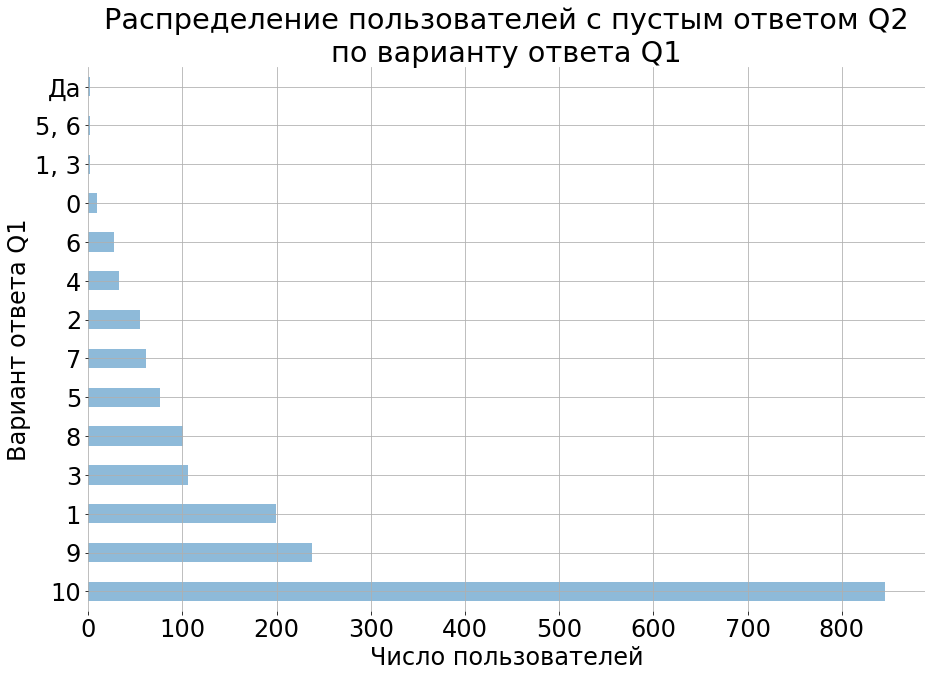

In [4]:
def plot_bar(df):
  ax = df.plot.barh(figsize=(15,10), alpha=0.5, grid='on')
  plt.box(None)
  return ax
plt.rcParams['font.size'] = 24
plot_bar(df[df.Q2.isna()].groupby('Q1')['user_id'].count().nlargest(14))
plt.xlabel('Число пользователей')
plt.ylabel('Вариант ответа Q1')
_ = plt.title('Распределение пользователей с пустым ответом Q2\nпо варианту ответа Q1')


Пустой ответ на вопрос `Q2` не означает, что пользователь поставил более 8 баллов, так как среди пользователей не отвечавших на второй вопрос присутствуют такие, которые дали качеству связи оценку менее 9. При этом некоторые, большинство которых не приведены на графике выше в виду уникальности ответа, оставили, вместо числа в `Q1`, отзыв, явно, негативного характера. Можно предположить, что эти пользователи, просто не сочли нужным отвечать на второй вопрос. Проверим, как распределились оценки среди пользователей, ответивших на вопрос `Q2`.

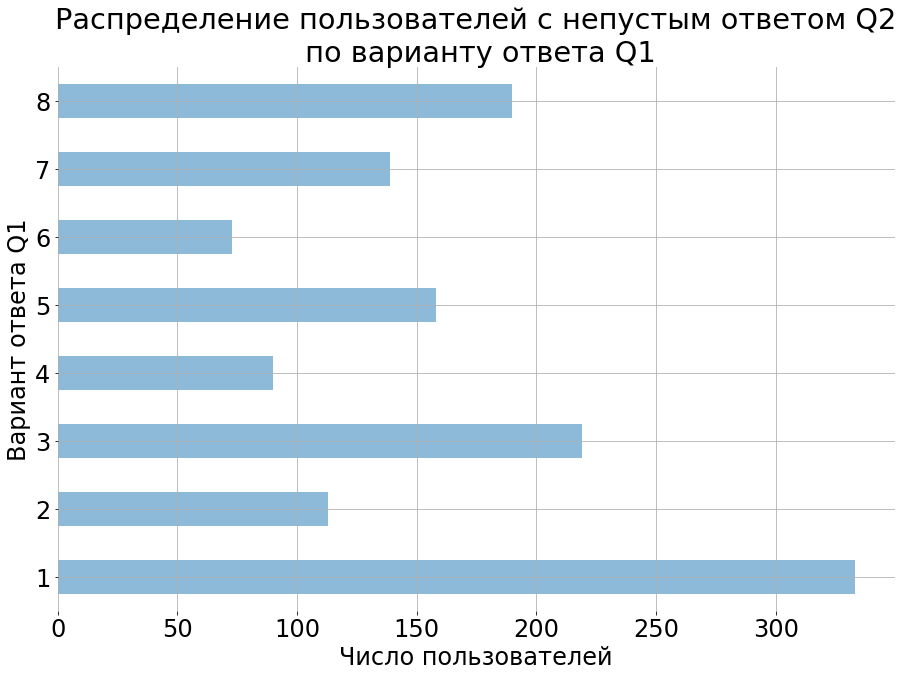

In [5]:
plot_bar(df[df.Q2.notna()].groupby('Q1')['user_id'].count())
plt.xlabel('Число пользователей')
plt.ylabel('Вариант ответа Q1')
_ = plt.title('Распределение пользователей с непустым ответом Q2\n по варианту ответа Q1')


Эта часть пользователей действительно поставила от 1 до 8 баллов в `Q1`. Предположительно, система просто не пропускала других респондентов к вопросу `Q2`. Таким образом, эта часть пользователей наиболее информативна. Пользователей, поставивших менее 9 балов и не имеющих ответа на второй вопрос, можно отнести к категории `Затрудняюсь ответить` - `6` на схеме. Для пользователей с числом балов в `Q1` 9 и более сделаем в `Q2` специальную категорию - `0`, которая просто заполняет нечисловые значения.

In [6]:
df.Q2[(df.Q2.isna()) & df.Q1.apply(lambda x: any([x == str(q) for q in range(1, 9)]))] = '6'
df.loc[(df.Q1 == '9') | (df.Q1 == '10'), 'Q2'] = '0'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         3058 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

После преобразования данных число пустых ответов в колонке `Q2` значительно сократилось. Сравним во множестве пустых ответов на вопрос `Q2` общее число ответов с числом уникальных ответов на вопрос `Q1`.

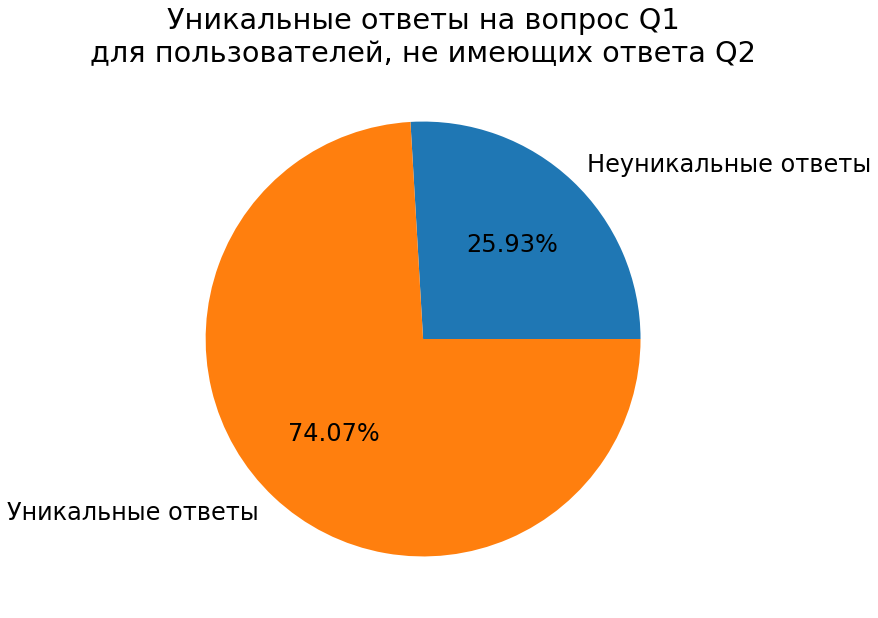

In [7]:
plt.figure(figsize=(15, 10))
_ = plt.pie(
    x=[len(df[df.Q2.isna()]) - len(df[df.Q2.isna()].Q1.unique()), len(df[df.Q2.isna()].Q1.unique())], 
    labels=['Неуникальные ответы', 'Уникальные ответы'],
    autopct=lambda x : f'{x:.2f}%')
_ = plt.title('Уникальные ответы на вопрос Q1\nдля пользователей, не имеющих ответа Q2')

Большинство ответов `Q1` среди пользователей, оставшихся, без ответа `Q2` уникально. Интересно посмотреть, какие ответы не уникальны

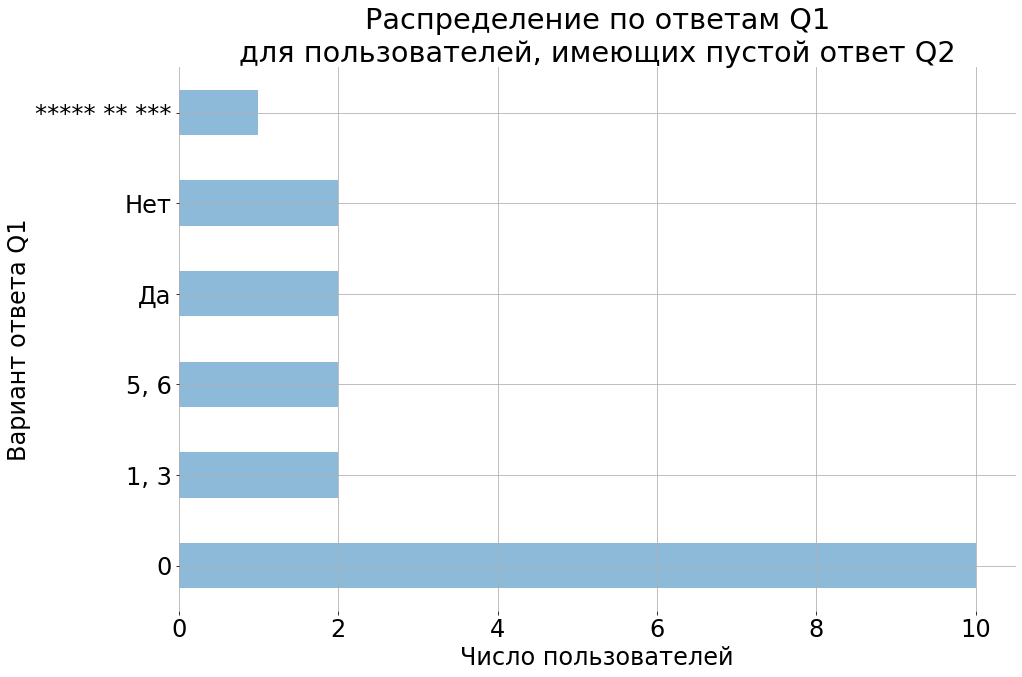

In [8]:
plot_bar(df[df.Q2.isna()].groupby('Q1')['user_id'].count().nlargest(6))
plt.xlabel("Число пользователей")
plt.ylabel("Вариант ответа Q1")
_ = plt.title("Распределение по ответам Q1\nдля пользователей, имеющих пустой ответ Q2")

Большинство оставшихся нестандартных ответов `Q1` - это нули. Примем их за минимально допустимую оценку `Q1 = 1` и ответ `Q2 = 6`: `Затрудняюсь ответить`. Остальные ответы `Q1` - это фразы или какие-то нестандартные числа и их последовательности, которые не представляют статистической ценности в виду своей уникальности, поэтому в данном исследовании мы их попросту отбросим, многие из этих ответов на графике не показаны. Заметим, что среди отброшенных ответов есть такие, которые могут быть трактованы, как положительные.

In [9]:
df.Q2[df.Q1 == '0'] = '6'
df.Q1[df.Q1 == '0'] = '1'
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3068 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3068 non-null   int64  
 1   Q1                                         3068 non-null   object 
 2   Q2                                         3068 non-null   object 
 3   Total Traffic(MB)                          3068 non-null   float64
 4   Downlink Throughput(Kbps)                  3068 non-null   float64
 5   Uplink Throughput(Kbps)                    3068 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3068 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3068 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3068 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3068 non-null   float64
 10  Web Average TCP RTT(ms) 

Итак, пропущенных значений теперь нет. При этом более 98% первоначальной выборки сохранено.

### Перевод данных в числовую форму

Некоторые варианты ответов `Q2`, идут списком через запятую: выделим каждое значение из списка в отдельный ряд.

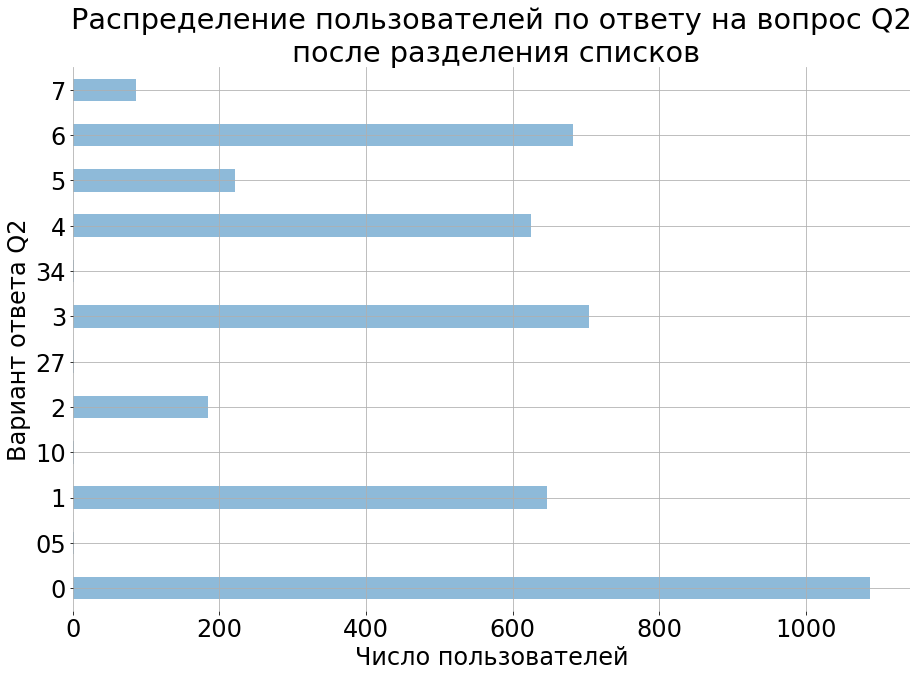

In [10]:
df.Q2 = df.Q2.str.split(',')
df = df.explode('Q2')
df.Q2 = df.Q2.str.strip()
plot_bar(df.groupby('Q2')['user_id'].count())
plt.title('Распределение пользователей по ответу на вопрос Q2\n после разделения списков')
plt.xlabel('Число пользователей')
_ = plt.ylabel('Вариант ответа Q2')

Некоторые ответы `Q2` состоят из двух цифр. Примем гипотезу, что у пользователя просто не получилось вставить запятую. На основании этого выделим каждую из цифр как отдельный вариант ответа `Q2`.

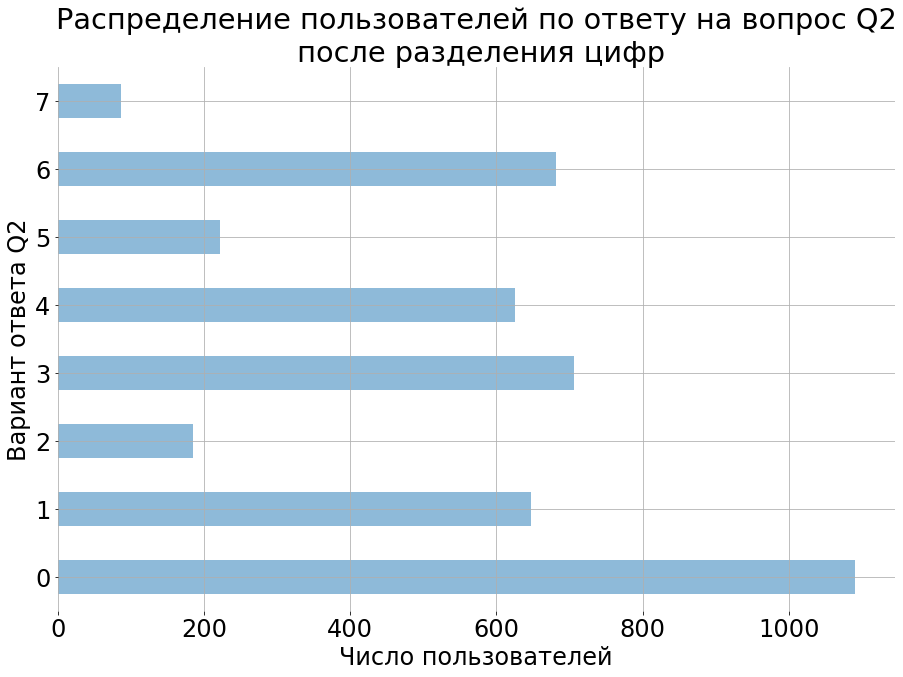

In [11]:
df.Q2 = df.Q2.apply(lambda x : [c for c in x])
df = df.explode('Q2')
plot_bar(df.groupby('Q2')['user_id'].count())
plt.title('Распределение пользователей по ответу на вопрос Q2\n после разделения цифр')
plt.xlabel('Число пользователей')
_ = plt.ylabel('Вариант ответа Q2')

Теперь остался только незадокументированный ответ `0` на вопрос `Q2` для случая `Q1` менее `9`, который тоже отнесем к варианту `6` - `Затрудняюсь ответить`, чтобы не cмешивать его с вариантом ответа на вопрос `Q1 = 9, 10`, для которого мы тоже приняли `0`.

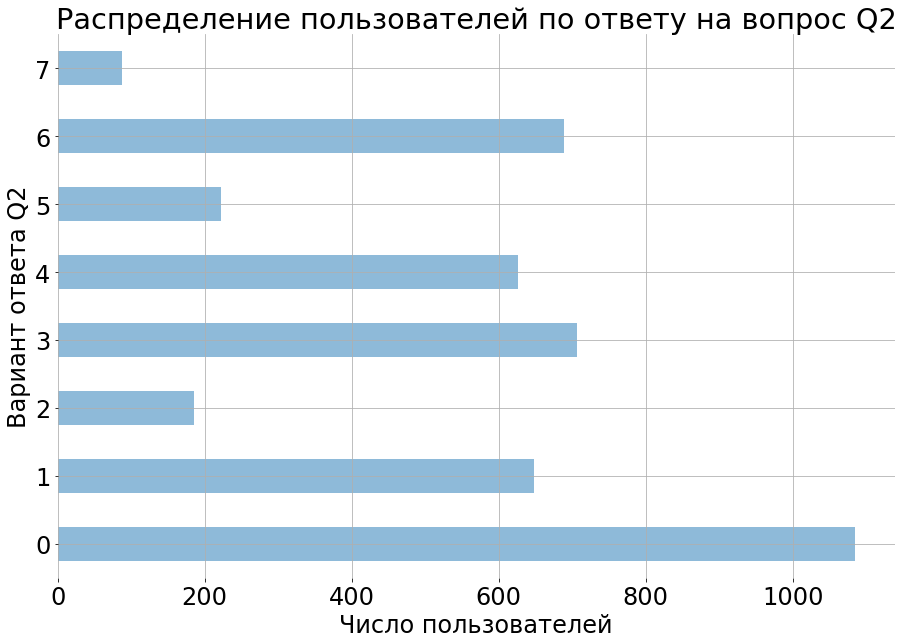

In [12]:
df.Q1 = df.Q1.astype(float)
df.loc[(df.Q2 == '0') & (df.Q1 < 9), :] = '6'
plot_bar(df.groupby('Q2')['user_id'].count())
plt.title('Распределение пользователей по ответу на вопрос Q2')
plt.xlabel('Число пользователей')
_ = plt.ylabel('Вариант ответа Q2')

Теперь все ответы соответствуют схеме, они выделены в отдельные ряды, пустые значения отсутствуют, можем перевести их в числовой вид и приступить к анализу гипотез.

In [13]:
df = df.astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4246 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    4246 non-null   float64
 1   Q1                                         4246 non-null   float64
 2   Q2                                         4246 non-null   float64
 3   Total Traffic(MB)                          4246 non-null   float64
 4   Downlink Throughput(Kbps)                  4246 non-null   float64
 5   Uplink Throughput(Kbps)                    4246 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        4246 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  4246 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        4246 non-null   float64
 9   Web Page Download Throughput(Kbps)         4246 non-null   float64
 10  Web Average TCP RTT(ms) 

# Связь ответа Q1 с параметрами сети


**Задача:** Проверить, что ответ на первый вопрос действительно зависит от параметров связи.

Посмотрим, наблюдаются ли какие-то корреляции ответов на вопрос `Q1` с параметрами сети. Мы можем предполгагать, что такие корреляции возможны, поскольку `Q1` - балльная оценка.

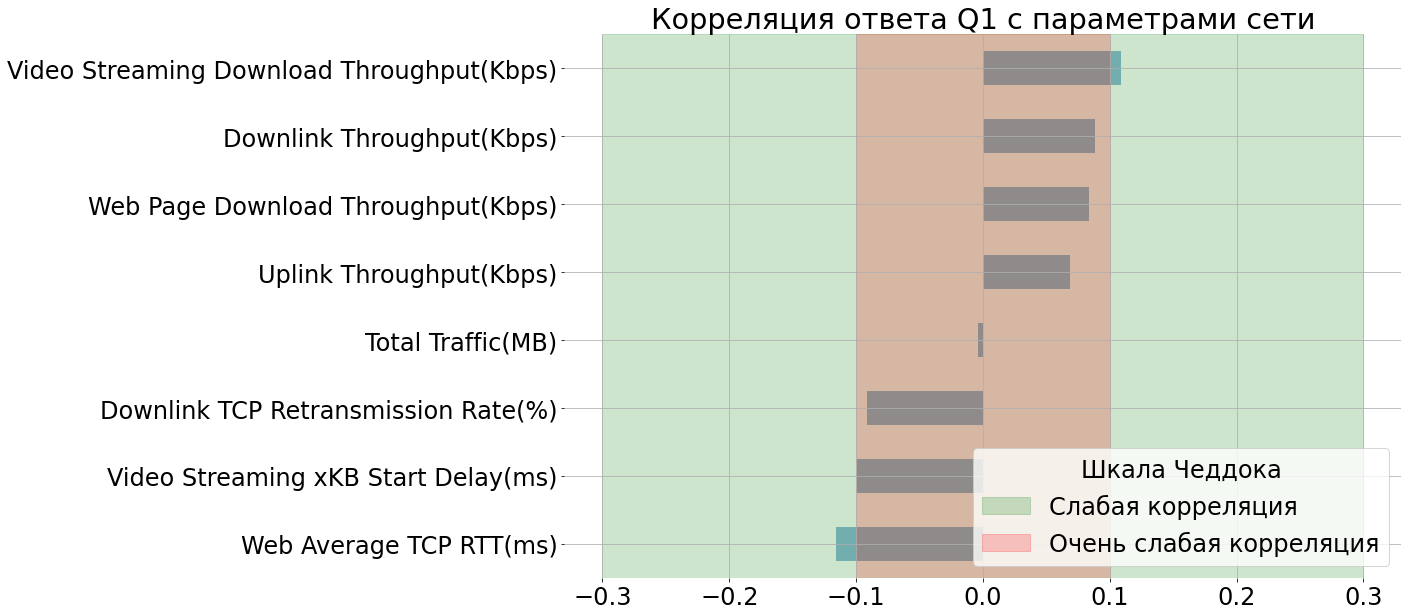

In [14]:
df_temp = df[set(df.columns) - {'user_id', 'Q2'}].drop_duplicates()
df_corr = df_temp.corr().Q1
df_corr = df_corr[df_corr.index != 'Q1']
plot_bar(df_corr.sort_values())
plt.title('Корреляция ответа Q1 с параметрами сети')
line1, line2 = (
    plt.axvspan(xmin=-0.3, xmax=0.3, label="Слабая корреляция", alpha=0.2, color='g'),
    plt.axvspan(xmin=-0.1, xmax=0.1, label="Очень слабая корреляция", alpha=0.2, color='r')
)
plt.legend([line1, line2], [line1.get_label(), line2.get_label()], title="Шкала Чеддока", loc='lower right')
df_corr = df_corr.to_frame()

Видим, что величина корреляции во всех случаях меняется от слабой  в интервале $[0.1, 0.3)$ до очень слабой в интервале $(0.0,0.1)$. При этом направление корреляции во всех случаях всегда совпадает с тем, что ожидается для каждого конткретного параметра сети ([см. описание данных](#Описание-данных)): отрицательным значениям корреляции соответствует запись `больше-хуже`, положительным - `больше-лучше`.

In [15]:
html_description_table = r'<table><tr><th>колонка в таблице данных</th><th>описание</th><th>доролнительное описание</th><th>как влияет</th></tr><tr><th>user_id</th><td>идентификатор абонента</td><td></td><td></td></tr><tr><th>Q1</th><td>ответ на первый вопрос</td><td></td><td></td></tr><tr><th>Q2</th><td>ответ на второй вопрос</td><td></td><td></td></tr><tr><th>Total Traffic(MB)</th><td>объем трафика передачи данных</td><td>Насколько активно абонент использует мобильный интернет</td><td></td></tr><tr><th>Downlink Throughput(Kbps)</th><td>средняя скорость «к абоненту»</td><td>Считается по всему трафику передачи данных.</td><td>больше-лучше</td><td></td></tr><tr><th>Uplink Throughput(Kbps)</th><td>средняя скорость «от абонента»</td><td>Считается по всему трафику передачи данных.</td><td>больше-лучше</td><td></td></tr><tr><th>Downlink TCP Retransmission Rate(%)</th><td>частота переотправок пакетов «к абоненту»</td><td>Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.</td><td>больше-хуже</td><td></td></tr><tr><th>Video Streaming Download Throughput(Kbps)</th><td>скорость загрузки потокового видео</td><td>меньше прерываний и лучше качество картинки</td><td>больше-лучше</td><td></td></tr><tr><th>Video Streaming xKB Start Delay(ms)</th><td>задержка старта воспроизведения видео</td><td>Сколько времени пройдёт между нажатием на кнопку Play<br> и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.</td><td>больше-хуже</td><td></td></tr><tr><th>Web Page Download Throughput(Kbps)</th><td>скорость загрузки web-страниц через браузер</td><td></td><td>больше-лучше</td><td></td></tr><tr><th>Web Average TCP RTT(ms)</th><td>пинг при просмотре web-страниц</td><td>Чем меньше, тем лучше — быстрее загружаются web-страницы</td><td>больше-хуже</td><td></td></tr></table>'
df_description = pd.read_html(html_description_table)[0]
df_description.index = df_description['колонка в таблице данных']
df_corr = df_corr.merge(right=df_description['как влияет'], left_index=True, right_index=True)
df_corr.columns = ['корреляция', 'как влияет']
df_corr[df_corr.index != 'Total Traffic(MB)']

,корреляция,как влияет
Video Streaming Download Throughput(Kbps),0.108632,больше-лучше
Downlink TCP Retransmission Rate(%),-0.091741,больше-хуже
Web Average TCP RTT(ms),-0.115756,больше-хуже
Downlink Throughput(Kbps),0.088603,больше-лучше
Web Page Download Throughput(Kbps),0.083826,больше-лучше
Video Streaming xKB Start Delay(ms),-0.099348,больше-хуже
Uplink Throughput(Kbps),0.068822,больше-лучше


## Гипотеза: направление корреляции ответа на вопрос Q1 с параметрами сети не случайное
**H0**: наблюдаемая корреляция ответов `Q1` с параметрами сети - чисто случайна <br>
**H1**: корреляция ответов `Q1` с параметрами сети имеется, и она отражена в данных<br>
Если предположить независимость корреляций, то каждый уникальный набор направленний корреляции будет иметь одинаковую вероятность. Однако, в данном случае это может быть не так, поскольку разные параметры сети могут сильно коррелировать друг с другом. Например, если мы наблюдаем корреляцию с ответом на вопрос по одному из этих параметров, то мы будем наблюдать также корреляции по параметрам, которые коррелируют с данным. Поэтому имеет смысл рассмотреть, как коррелируют ответы на вопрос с главными компонентами пространства параметров сети, поскольку в пространстве главных компонент переменные не скоррелированы по определению.

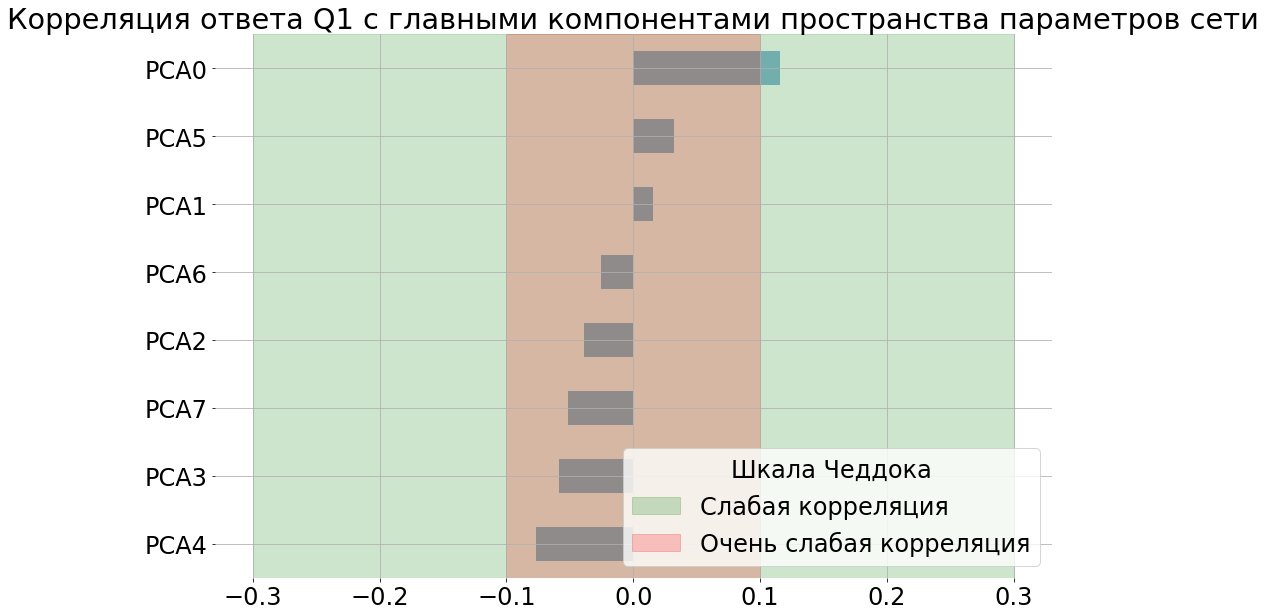

In [16]:
# Исключим влияние корреляций между параметрами сети, для этого найдем величину коэффициентов корреляции пирсона в пространстве главных компонент
cols_to_remove = {'Q1', 'user_id'} #Эти колонки не участвуют в вычислении компонент: только параметры сети
X = (df_temp[set(df_temp.columns) - cols_to_remove] - df_temp[set(df_temp.columns) - cols_to_remove].mean()).values
U, S, V = np.linalg.svd(X, full_matrices=False)
# Сделаем датафрейм с главными компонентами
df_pca = df_temp.Q1.to_frame()
for i,_ in enumerate(set(df_temp.columns) - cols_to_remove):
  df_pca[f'PCA{i}'] = U[:, i]
#Вычисляем корреляцию с главными компонентами
df_corr = df_pca.corr()
df_corr['Q1'][df_corr.index != 'Q1'].sort_values()\
  .plot.barh(
      figsize=(15, 10), 
      grid='y', 
      title='Корреляция ответа Q1 c главными компонентами пространства параметров сети',
      alpha=0.5)
line1, line2 = (
    plt.axvspan(xmin=-0.3, xmax=0.3, label="Слабая корреляция", alpha=0.2, color='g'),
    plt.axvspan(xmin=-0.1, xmax=0.1, label="Очень слабая корреляция", alpha=0.2, color='r')
)
plt.legend([line1, line2], [line1.get_label(), line2.get_label()], title="Шкала Чеддока", loc='lower right')
plt.box(None)

Тут корреляции менее заметны, чем напрямую с параметрами сети, что говорит о том, что реальная корреляция близка скорее к очень слабой, но наблюдаемая может быть немного больше из-за того, что параметры сети скоррелированы друг с другом. Самый большой коэффициент корреляции наблюдается с первой главной компонентой. Оценим его значимость методом бутстреп. При использовании метода бутстреп предполагаем, что значения `PCA0` и `Q1` образуют две генеральных совокупности, из которых мы псевдо-случайным сэмплированием с замещением выбираем два числа, которые образуют новую пару значений `Q1, PCA0`. Таким образом набираем число пар, раное числу строк в исходной таблице данных. Для набранных пар, вычисляем коэффициент корреляции между значениями `Q1` и `PCA0` в полученных парах. Для рассчитанных значений коэффициентов корелляции строим гистограмму, по которой оцениваем значение `p-value` наблюдающегося коэффициента корреляции.

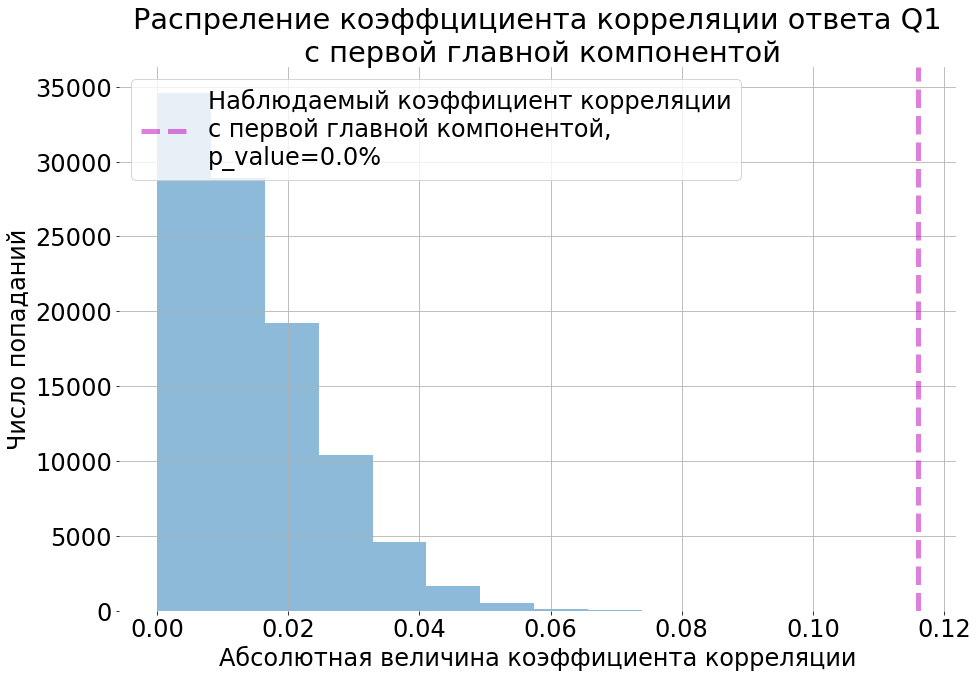

In [17]:
# Сохраняем результаты в файл, чтобы не пересчитывать всякий раз
corr_cache_file = "cache.txt"
if os.path.exists(corr_cache_file):
  corr = np.loadtxt(corr_cache_file)
else:
  # Задаем число розыгрышей
  N = 100000 
  # Считаем корреляцию между двумя квази-случайнми выборками: одна из колонки Q1 - вторая из колонки PCA0
  corr = np.array([
    np.corrcoef(np.random.choice(df_temp.Q1, size=len(df_temp)), np.random.choice(df_pca.PCA0, size=len(df_pca)))[0, 1]
    for _ in range(N)])
  # Сохраняем результат
  np.savetxt(corr_cache_file, corr)
plt.figure(figsize=(15, 10))
plt.hist(np.abs(corr), alpha=0.5)
plt.box(None)
plt.title(f"Распреление коэффцициента корреляции ответа Q1\n с первой главной компонентой")
plt.axvline(np.abs(df_corr.loc['Q1', 'PCA0']), ls='--', color='m', alpha=0.5, lw=5)
plt.xlabel('Абсолютная величина коэффициента корреляции')
plt.ylabel('Число попаданий')
plt.grid('on')
_ = plt.legend(
    [f"Наблюдаемый коэффициент корреляции\nс первой главной компонентой,\np_value={(corr > np.abs(df_corr.loc['Q1', 'PCA0'])).sum() / len(corr) * 100}%"], 
    loc='upper left')

**Вывод:** Достоверность гипотезы **H0** о случайности наблюдаемого коэффициента корреляции близка к нулю. Поэтому, не смотря на слабость корреляции главной компоненты и ответа на вопрос `Q1`, величина этой корреляции статистически значима, таким образом мы можем принять гипотезу **H1** о наличии корреляций с достоверностью, близкой к 100% <br><br>
**Дальнейшее направление исследований:**
* Перевести корреляции из шкалы Чеддока в нормальную шкалу, определив для каждого найденного коэффициента корреляции, его значение p-value, и, разбив корреляции по интервалам p-value, сделать выводы о достоверности каждой из корреляций
* Для корреляций, которые определены, как достоверные, найти вклад от каждого из параметров сети в соответствующую компоненту, проанализировать результат и сделать выводы

# Первый вопрос и объем интернет траффика
**Задача:** Проверить, что ответ на вопрос `Q1` коррелирует с величиной `Total Traffic(MB)`  

Построим распределение величины `Total Traffic(MB)` от варианта ответа на вопрос `Q1`.

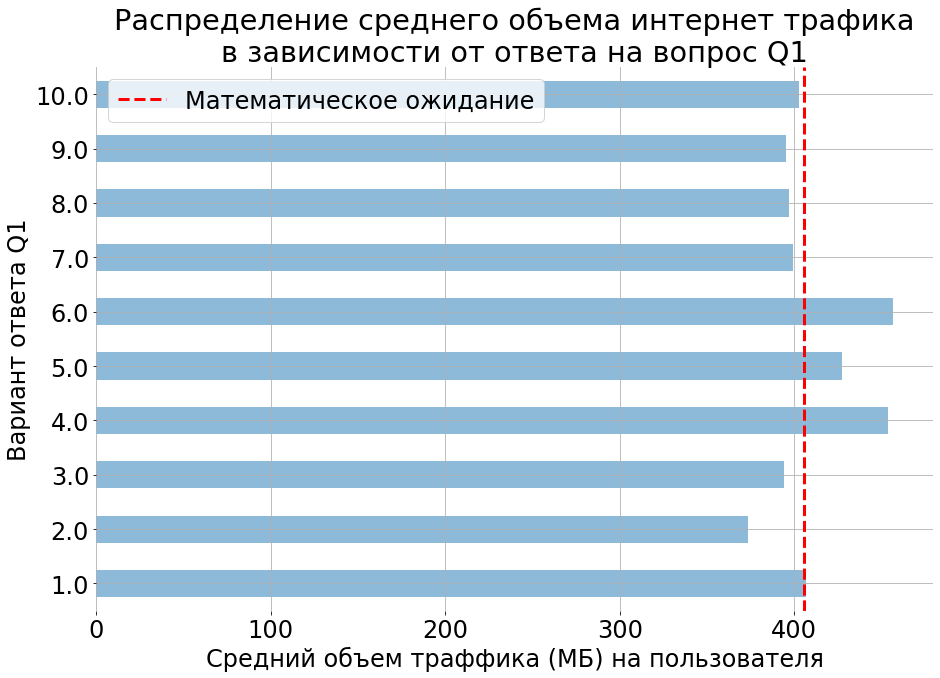

In [18]:
df_temp[['Q1', 'Total Traffic(MB)']].groupby('Q1').mean().plot.barh(
    title="Распределение среднего объема интернет трафика\nв зависимости от ответа на вопрос Q1", 
    figsize=(15,10), alpha=0.5, grid='both')
plt.box(None)
plt.ylabel('Вариант ответа Q1')
plt.xlabel('Средний объем траффика (МБ) на пользователя')
plt.legend().remove()
expectation = df_temp['Total Traffic(MB)'].mean()
_ = plt.axvline(expectation, color='r', ls='--', lw=3)
_ = plt.legend(['Математическое ожидание'])

Cредняя величина `Total Traffic(MB)` немного отличается между вариантами, но эти отличия не выглядят существенными.

## Гипотеза: отличия величины Total Traffic (MB) не значимы между пользователями, сгруппированными по признаку ответа на вопрос Q1



**H0:** Средние величины `Total Traffic(MB)` по каждому из вариантов ответов не отличаются значимо от общей средней величины `Total Traffic(MB)` <br>
**H1** Средние величины `Total Traffic(MB)` по какому-то из вариантов ответов существенно отличаются от общего среднего

Распределение средней величины `Total Traffic(MB)` по каждой из груп пользователей достаточно точно описывается законом нормального распределения, согласно центральной предельной теоремме, поэтому в качестве теста допустимо использовать двусторонний t-критерий.

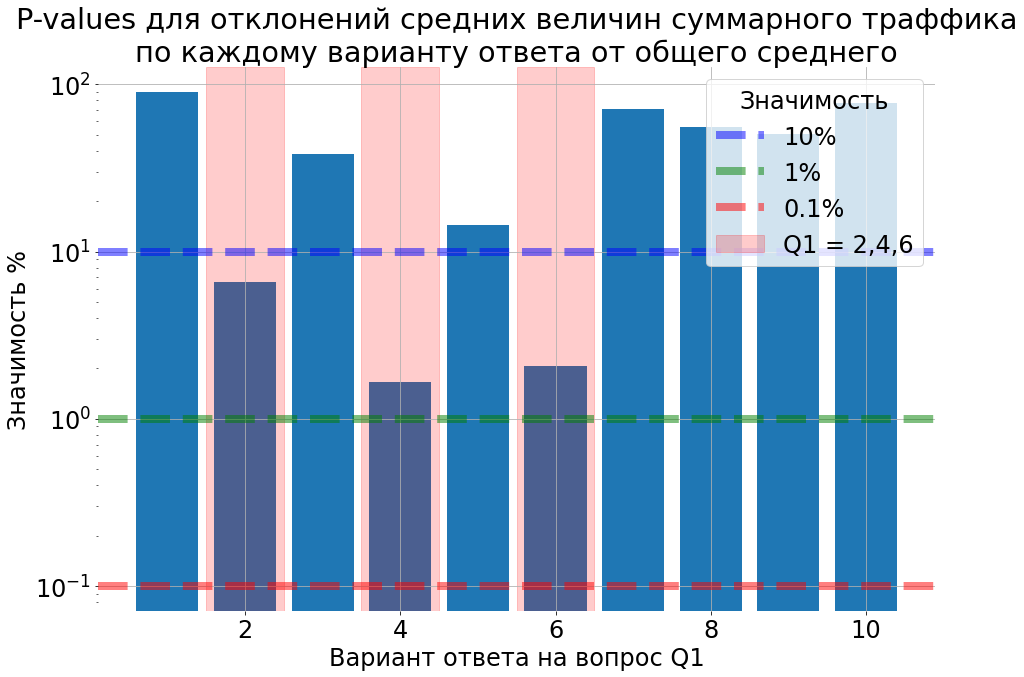

In [19]:
p_values = [
            ttest_ind(df_temp['Total Traffic(MB)'], df_temp.loc[df_temp.Q1 == Q1, 'Total Traffic(MB)']).pvalue
            for Q1 in np.arange(1,11)]
plt.figure(figsize=(15,10))
plt.bar(np.arange(1,11), np.array(p_values)*100)
plt.gca().set_yscale('log')
plt.grid('minor')
plt.box(None)
plt.axhline(10, color='b', alpha=0.5, lw=8, ls='--')
plt.axhline(1, color='g', alpha=0.5, lw=8, ls='--')
plt.axhline(0.1, color='r', alpha=0.5, lw=8, ls='--')
plt.title("P-values для отклонений средних величин суммарного траффика\nпо каждому варианту ответа от общего среднего")
plt.ylabel("Значимость %")
plt.axvspan(1.5, 2.5, color='r', alpha=0.2)
plt.legend(["10%", "1%", "0.1%", "Q1 = 2,4,6"], title="Значимость")
plt.axvspan(3.5, 4.5, color='r', alpha=0.2)
plt.axvspan(5.5, 6.5, color='r', alpha=0.2)
_ = plt.xlabel("Вариант ответа на вопрос Q1")

**Вывод** На уровне значимости 90% отличия средних значений `Total Traffic(MB)` для вариантов ответов `Q1` `2, 4, 6` являются существенными, однако уже на уровне значимости 99% - это не так. Возможно, что большие отклонения для вариантов `2, 4, 6` объясняются просто слишком малым числом респондентов в выборке с такими вариантами ответа (см. рис. ниже), и, как итог, существенным отклонением результирующего распределения от распределения Стьюдента. В любом случае разброс средних величин суммарного трафика между респондентами, сгруппированными по варианту ответа на вопрос `Q1`, не является достаточно существенным, чтобы уверенно утверждать, что есть какая-то корреляция варианта ответа `Q1` и `Total Traffic(MB)`: все колебания средних значений `Total Traffic(MB)` между выборками по варианту ответа `Q1` можно объяснить статистическими флуктуациями.<br><br>
**Дальнейшее направление исследований:**
* Можно попытаться аппроксимировать аппроксимировать величину траффика экспоненциальным распределением (если построить гистограмму, то можно увидеть, что она достаточно хорошо им описывается)
* Эту же гипотезу можно проверить с использованием метода бутстреп. Существует два способа, как это можно сделать: первое, просто использовать пул всех значений `Total Traffic(MB)`, из которого набирать тестовые выборки, второе, генерить псевдо-случайные значения `Total Traffic(MB)`, используя аппроксимацию экспоненциальным определением найденную в предыдущем пунке
* Проверить, что маленькое число вариантов `Q1 = 2, 4, 6` определяется удобством расположения клавиш на клавиатуре. Это может быть полезно, так как позволяет исключить влияние факторов, не связанных с сетью на оценку пользователя. Возможно, предложить и проанализировать другие варианты таких факторов

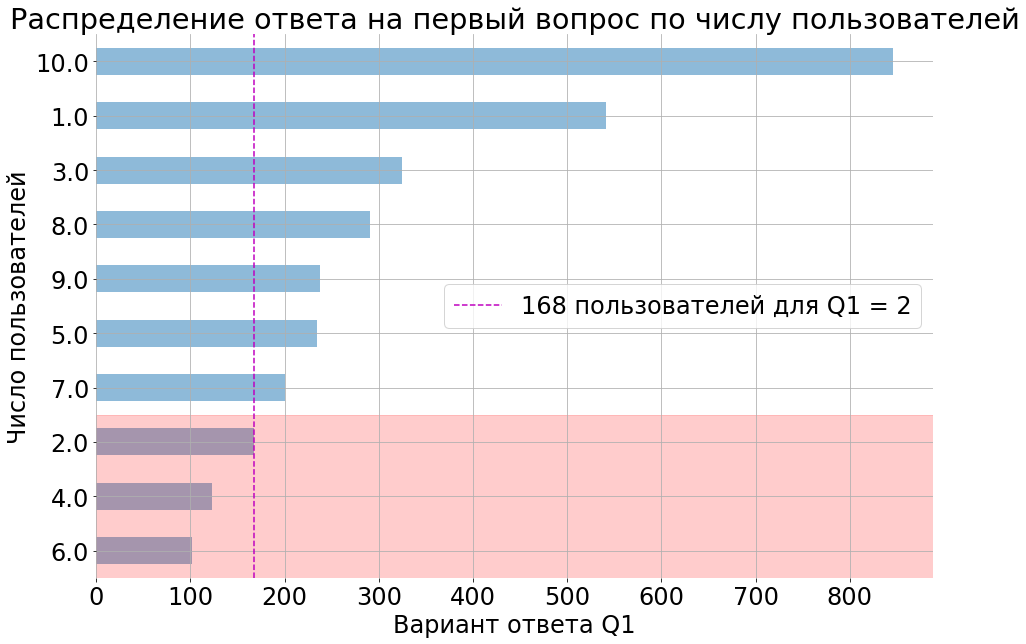

In [20]:
plot_bar(df_temp.groupby('Q1')['Total Traffic(MB)'].count().to_frame().sort_values('Total Traffic(MB)'))
plt.ylabel('Число пользователей')
plt.xlabel('Вариант ответа Q1')
plt.title("Распределение ответа на первый вопрос по числу пользователей")
plt.axhspan(ymin=-1, ymax=2.5, color='r', alpha=0.2)
plt.axvline(df_temp[df_temp.Q1 == 2]['Total Traffic(MB)'].count(), color='m', linestyle='--')
_ = plt.legend([f"{df_temp[df_temp.Q1 == 2]['Total Traffic(MB)'].count()} пользователей для Q1 = 2"])

# Связь ответа Q2 с ответом Q1
**Задача:** проверить связь ответов `Q1` и `Q2`, чтобы понять какие проблемы с сетью повлияли на оценку пользователей наиболее негативным образом.

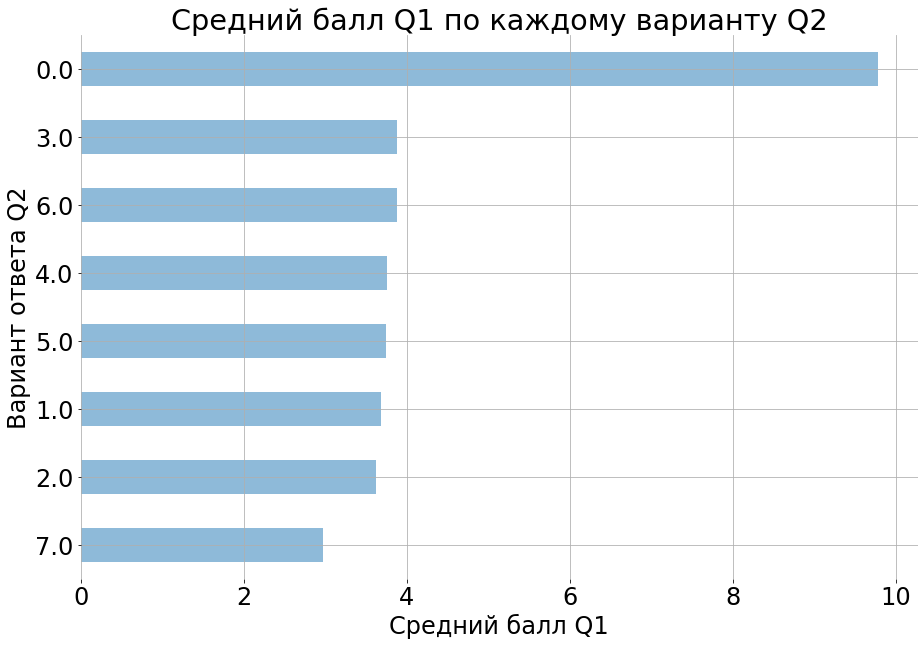

In [21]:
plot_bar(df.groupby('Q2')['Q1'].mean().sort_values().to_frame())
plt.gca().legend().remove()
plt.title('Средний балл Q1 по каждому варианту Q2')
plt.ylabel('Вариант ответа Q2')
_ = plt.xlabel('Средний балл Q1')

Как и следовало ожидать, наиболее высокий средний балл у варианта `Q2 = 0`, этот результат не очень интересен: он соответствует баллам в `Q1 = 9, 10`. Рассмотрим оставшиеся варианты.

## Гипотеза: отличия средней величины балла Q1 для разных вариантов Q2 не существены
**H0:** Средняя величина `Q1` по каждому из вариантов `Q2` не отличается от общей средней величины `Q1`. <br>
**H1:** Средняя величина `Q1` по какому-то из вариантов существенно отличается от общего среднего.

Как и ранее, для зависимости `Total Traffic(MB)` и `Q1` тут можно воспользоваться t-тестом. Заметим, что вариант `Q1 = 9, 10`, который соответствует `Q2 = 0` мы не рассматриваем. 

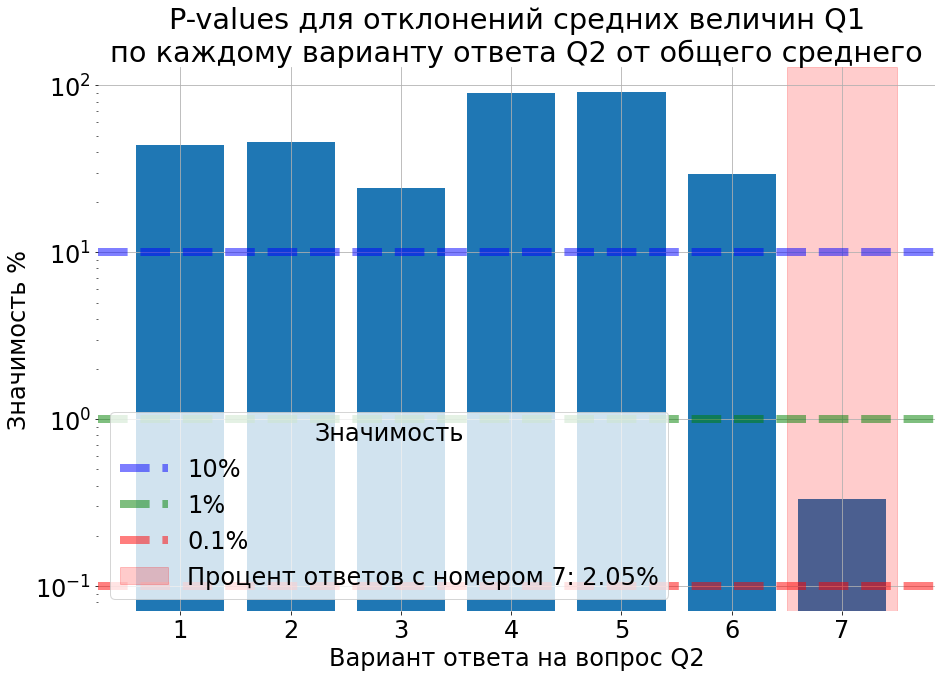

In [22]:
p_values = [ttest_ind(df[df.Q2 != 0].Q1, df[df.Q2 == Q2].Q1).pvalue for Q2 in np.arange(1,8)]
plt.figure(figsize=(15,10))
plt.bar(np.arange(1,8), np.array(p_values)*100)
plt.gca().set_yscale('log')
plt.grid('minor')
plt.box(None)
plt.axhline(10, color='b', alpha=0.5, lw=8, ls='--')
plt.axhline(1, color='g', alpha=0.5, lw=8, ls='--')
plt.axhline(0.1, color='r', alpha=0.5, lw=8, ls='--')
plt.title("P-values для отклонений средних величин Q1\nпо каждому варианту ответа Q2 от общего среднего")
plt.ylabel("Значимость %")
plt.axvspan(6.5, 7.5, color='r', alpha=0.2)
plt.legend(["10%", "1%", "0.1%", f"Процент ответов с номером 7: {len(df[df.Q2 == 7]) / len(df) * 100:.2f}%"], title="Значимость", loc="lower left")
_ = plt.xlabel("Вариант ответа на вопрос Q2")

Все варианты, кроме варианта `Q2 = 7` отличаются от общего среднего в пределах значимости 90%, поэтому для них мы принимаем гипотезу **H0**, об отсутствии отличий между этими вариантами. Для варианта `Q2 = 7` мы ее отвергаем на уровне значимости 1%. Таким образом, среднее значение `Q1` для ответа на вопрос `Q2 = 7` значимо отличается от общего среднего `Q1`. Вариант ответа `Q2 = 7` - это `Свой вариант` на схеме, следовательно, никакой дополнительной информации о параметрах сети этот ответ не несет. Возможно, это просто негативная реакция пользователя на сам факт опроса, которой бы более подошла графа: `Не ваше дело`. Посмотрим, насколько существенной является выборка `Q2 = 7`.

In [23]:
print(f'Процент ответов Q2 = 7: {len(df[df.Q2 == 7]) / len(df) * 100:.2f}%')

Процент ответов Q2 = 7: 2.05%


Выборка с вариантом ответа `Q2 = 7` не является существенной, и составляет всего 2% от общего числа ответов. Учитывая тот факт, что данный ответ пользователь мог поставить просто, находясь под влиянием случайного аффекта чувств, отклонение среднего значения `Q1` по данному вопросу мы также можем принять не существенным.

# Итоги

1. Проведен статистический анализ данных
2. Проверено три гипотезы относительно представленных данных
3. Принята гипотеза о наличии корреляций варианта ответа `Q1` с параметрами сети
4. Принята гипотеза об отсутствии разницы среднего значения `Тотal Traffic(MB)` для разных вариантов ответа `Q1` от общего среднего
5. Принята гипотеза об отсутствии разницы среднего значения `Q1` для вариантов ответа `Q2 = 1-6` от общего среднего
6. Принята гипотеза о существенном отличии среднего значения `Q1` для варианта ответа `Q2 = 7` от общего среднего
7. Существенное отличие среднего значения `Q1` для варианта `Q2 = 7`, по-видимому, не связано с услугами связи, а объясняется чисто психологическими факторами
8. В виду п.7 стоит признать это отличие не существенным, так как подавляющая часть психологического фона абонентов находится вне сферы влияния компании МегаФон.

# Рекомендации
1. Проводить опросы, в которых пользователь ставит оценки, на небольшое число хорошо подобранных вопросов: респонденту сложнее ориентироваться в вариантах ответов, и это может вызвать раздражение, которое повляет на результат опроса
2. Делать структуру опроса такой, чтобы респондент не чувствовал, что он оправдывается за поставленную плохую оценку, как это происходит сейчас с ответами `Q1` и `Q2` - респондент ставит оценку, которую считает нужным, а в `Q2` должен объяснять, почему
3. Проводить не социологические опросы, а анализировать конкретные технические характеристики сети в зависимости от примнимаемых мер по их улучшению: установки новых антенн, замены оборудования и тп: про сами технические характеристики сети и так уже, примерно, известно, как они повлияют на настроение пользователей: проводить социологические опросы более оправдано по отношению к конкретным акциям, тарифам, какие услуги вы бы хотели иметь в своем тарифе и тп.
5. Ну, и видим, что оценка пользователей действительно более-менее адекватно зависит от технических характеристик сети. Можно определить от каких технических характеристик она зависит сильнее и стараться менять только их, если такое выборочное изменение характеристик возможно